# Trading Strategies

The trem algorithmic trading strategy is used to describe any type of financeil trading strategy that us based on an algorithmic designed to take long, short, or neutral positions in financial instruments on its own without human interference. The chapter focuses on the technical aspects of the vectorized backtesting approach for a selected few such strategies.

Another focus of the chapter is the application of machine and deep learning algorithm to formualte algorithmic trading stategies.

## Simple Moving Averates

### Data Import

In [2]:
# import packages
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import seaborn as sns

sns.set()
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
raw = pd.read_csv('./source/tr_eikon_eod_data.csv', index_col=0, parse_dates=True)

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


In [5]:
symbol = 'AAPL.O'

data = (
    pd.DataFrame(raw[symbol]).dropna()
)

### Trading Strategy

The calculation of the SAM values for two dirrerent rolling window sizes. 

<Axes: xlabel='Date'>

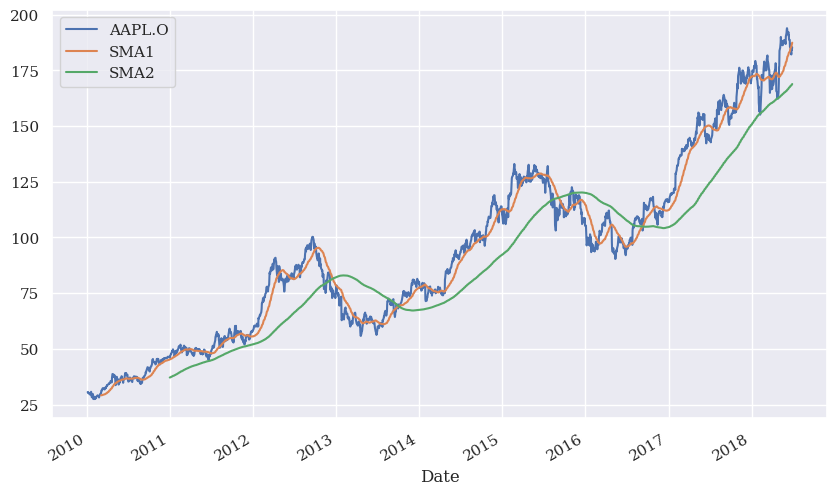

In [6]:
SMA1 = 42           # Calculates the values for the shorter SMA
SMA2 = 252          # Calculates the values fot the longer SMA

data['SMA1'] = data[symbol].rolling(SMA1).mean()
data['SMA2'] = data[symbol].rolling(SMA2).mean()

data.plot(figsize=(10, 6))

The derivation of the positions. The traing rule are:

- Go long (= +1) when the shorter SMA is above the longer SMA.

- Go short (= -1) when the shorter SMA is below the longer SMA

The poisitons are visualized below.

In [7]:
data.dropna(inplace=True)

data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1) 

data.tail()

,AAPL.O,SMA1,SMA2,Position
Date,,,,
2018-06-25,182.17,185.606190,168.265556,1
2018-06-26,184.43,186.087381,168.418770,1
2018-06-27,184.16,186.607381,168.579206,1
2018-06-28,185.50,187.089286,168.736627,1
2018-06-29,185.11,187.470476,168.901032,1


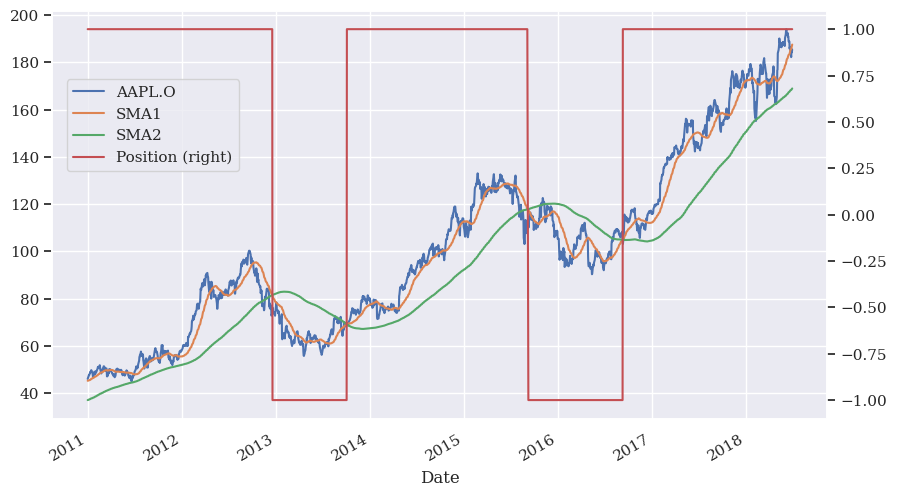

In [8]:
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

### Vectorized Backtesting

First, the log returns are calculated. Then the positionings, represented as +1 or -1, are muliplied by the relevant log return. This simple calculation is possible since a long position earns the return of the Apple stock and a short position earns the negative return of the Apple stock. Finally, the log returns for the Apple stock and the algorithmic traing strategy based on SMAs need to be added up and the exponential function applied to arriva at the performace values.

In [9]:
# calculates the log returns of the Apple stock
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))          

data['Strategy'] = data['Position'].shift(1) * data['Returns']          # Multiplies the postion values, shifted by one day, by the log returns of the Apple stock; the shift is required to avoid a foresight bias

In [10]:
data.round(4).head()

,AAPL.O,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2010-12-31,46.0800,45.2810,37.1207,1,NaN,NaN
2011-01-03,47.0814,45.3497,37.1862,1,0.0215,0.0215
2011-01-04,47.3271,45.4126,37.2525,1,0.0052,0.0052
2011-01-05,47.7142,45.4661,37.3223,1,0.0081,0.0081
2011-01-06,47.6757,45.5226,37.3921,1,-0.0008,-0.0008


In [11]:
data.dropna(inplace=True)

In [12]:
# Sums up the log returns for the stategy and the benchmark investment and calculates the exponential value to arrive at the absolute performance
np.exp(data[['Returns', 'Strategy']].sum())

Returns     4.017148
Strategy    5.811299
dtype: float64

In [13]:
# calculates the annualized volatility for the strategy and the benchmark investment
data[['Returns', 'Strategy']].std() * 252 ** 0.5            

Returns     0.250571
Strategy    0.250407
dtype: float64

The numbers show that the algorithmic trading strategy indeed outperforms the benchmark investment of passively holding the Apple stock.

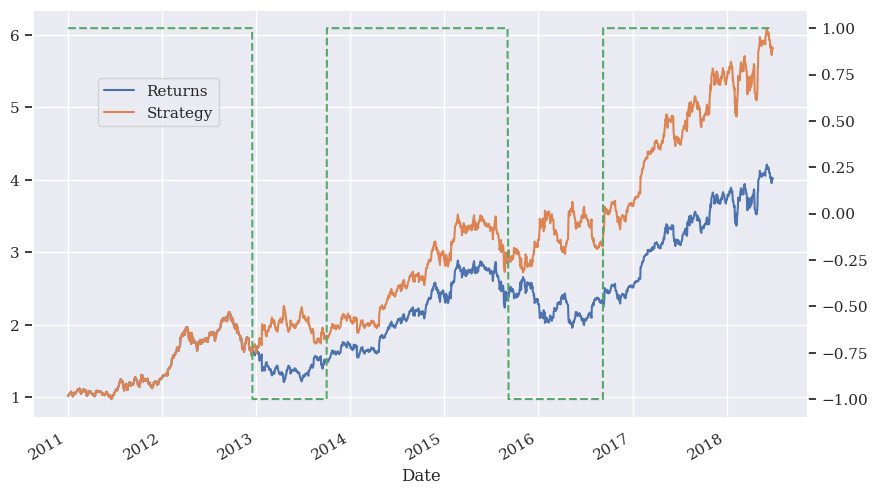

In [14]:
ax = data[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

### Optimization

A natural question that arises is if the chosen parameters `SMA1=42` and `SMA2=252` are the right ones. In general, investors prefer higher returns to lower returns ceteris paribus. A brute force approach can be used that simply repeats the whole vectorized backtesting.

In [15]:
from itertools import product

In [16]:
sma1 = range(20, 61, 4)         # specifies the parameter values for SMA1
sma2 = range(180, 281, 10)       # specifies the parameter values for SMA2

In [17]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())

    # records the vectorized backtesting results in a DataFrmae object
    results = results.append(pd.DataFrame(
        {'SMA1': SMA1,
         'SMA2': SMA2,
         'MARKET': perf['Returns'],
         'STRATEGY': perf['Strategy'],
         'OUT': perf['Strategy'] - perf['Returns']}, 
         index=[0]
    ), ignore_index=True)

/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_64693/2349791034.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(
/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_64693/2349791034.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(
/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_64693/2349791034.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(
/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_64693/2349791034.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = r

The following code gives an overview of the results and shows the seven best-performing parameter combinations of all those backtested. The ranking is implemented according to the outperformace of the algorithmic traiding strategy compared to the benchmark investment. The performace of the benchmark investment varties since the choice of the `SMA2` parameter influences the length of the time interval and data set on which the vectorized backtest is implemented.

In [18]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      121 non-null    int64  
 1   SMA2      121 non-null    int64  
 2   MARKET    121 non-null    float64
 3   STRATEGY  121 non-null    float64
 4   OUT       121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


In [19]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.650342,7.175173,2.524831
39,32,240,4.045619,6.558690,2.513071
59,40,220,4.220272,6.544266,2.323994
46,36,200,4.074753,6.389627,2.314874
55,40,180,4.574979,6.857989,2.283010
70,44,220,4.220272,6.469843,2.249571
101,56,200,4.074753,6.319524,2.244772


According to the brute force-based optimization, `SMA=40` and `SMA=190` are the optimal parameters. However, this result is heavily dependent on the data set used and is prone to overfitting. A more rigorous approach would be to implement the optimization on one data set, the in-sample or training data set, and test it on another one, the out-of-sample or testing data set.

## Random Walk Hypothesis

These results are in contrast to what the random walk hypothesis (RWH) predicts, namely that such predictive approach should not yield any outperformance at all. The RWH postulates that prices in financail markets follow a random walk, or, in continuous time, an arithmetic Brownian motion without drift. The expected value of an arithmetic Brownian motion without drift at any point in the future equals its value today.

The RWH is consitent with the efficient markets hypothesis (EMH), which states market price reflect all available information.

OLS regression is then used to predict the market prices based on the lagged market prices create before. The basic idea is that the market prices from yesterday and four more days back can be used to predict today's market price.

In [23]:
# The following code implements this idea
# creates five lagged versions of the historical end-of-day closing levels of the S&P 500 stock index.

symbol = '.SPX'

data = pd.DataFrame(raw[symbol])

lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)      # defines a column name for the current lag value
    data[col] = data[symbol].shift(lag) # creates the lagged version of the market prices for the current lag value
    cols.append(col)        # collects the column names for later reference

data.head(7)

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1132.99,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.52,1132.99,NaN,NaN,NaN,NaN
2010-01-06,1137.14,1136.52,1132.99,NaN,NaN,NaN
2010-01-07,1141.69,1137.14,1136.52,1132.99,NaN,NaN
2010-01-08,1144.98,1141.69,1137.14,1136.52,1132.99,NaN
2010-01-11,1146.98,1144.98,1141.69,1137.14,1136.52,1132.99


In [24]:
data.dropna(inplace=True)

As the optimal regression parameters show, `lag_1` indeed is the most important one in predicting the market price based on OLS regression. Its value is close to 1. The other values are rather close to 0.

In [26]:
reg = np.linalg.lstsq(data[cols], data[symbol], rcond=-1)[0]

reg.round(3)

array([0.966, 0.005, 0.025, 0.   , 0.003])

Text(0.5, 1.0, 'Optimal regression parameters from OLS regression for price prediction')

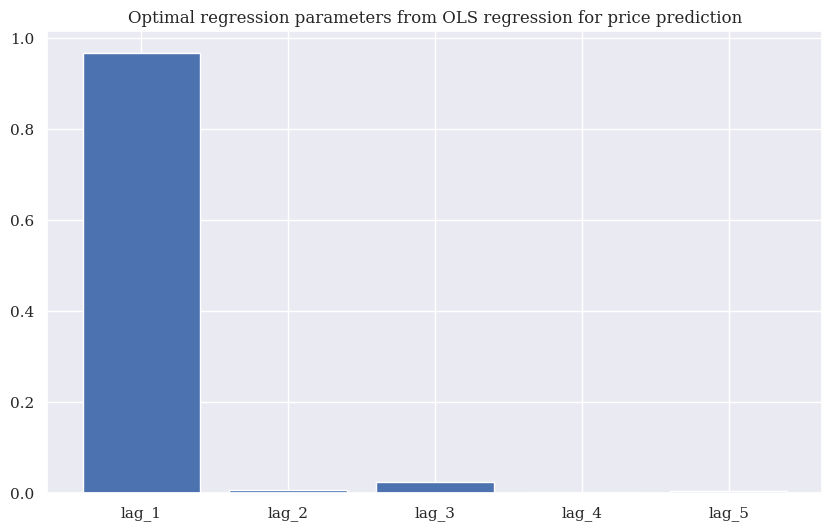

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(cols, reg)
plt.title('Optimal regression parameters from OLS regression for price prediction')

It becomes obvious from the figure below that indeed `lag_1` is basically what is used to come up with the prediction value. Graphically speaking, the prediction line is the origianl times series shifted by one day to the right.

In [28]:
data['Prediction'] = np.dot(data[cols], reg)

Text(0.5, 1.0, 'S&P 500 levles compared to prediction values from OLS regression')

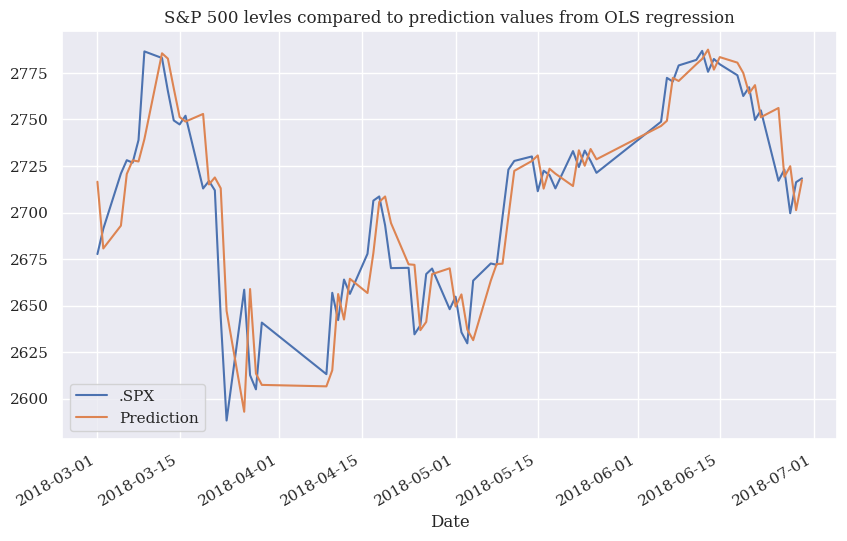

In [32]:
data[[symbol, 'Prediction']].iloc[-75:].plot(figsize=(10, 6))
plt.title('S&P 500 levles compared to prediction values from OLS regression')

The brief anaylsis in this section reveals some support for both the RWH and EMH. The RWH and EMH are among the financial theories that have broad empirical support. In that sense, any algorithmic trading strategy must prove its worth by proving the RWH does not apply in general. This for sure is a tough hurdle.

## Linear OLS regression

This section applies linear OLS regression to predict the direction of market movements based on historical log returns. To keep thing simple, only two features are used. The first feature (`lag_1`) represents the log returns of the financial times series lagged by one day. The second features (`lag_2`) lags the log returns by two days. Log returns - in constast to prices - are stationary in general, which often is a necessary option for the application of statistical and ML algorithms.

The basic idea behind the usage of lagged log returns as features is that they might be informative in predicting future returns. For exmaple, one might hypothesize that after two downward movements an upward movement is more likely ('mean reversion'), or to the contrary that another downward movement is more likely ('momentum' or 'trend').

### The Data

In [33]:
# figure below shoes the frequency distribution of the daily historical log returns for the EUR/USD exchange rate.

raw = pd.read_csv('./source/tr_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()

raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [34]:
symbol = 'EUR='

In [35]:
data = pd.DataFrame(raw[symbol])

In [36]:
data['returns'] = np.log(data / data.shift(1))

In [37]:
data.dropna(inplace=True)

In [38]:
data['direction'] = np.sign(data['returns']).astype(int)

In [39]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


Text(0.5, 1.0, 'Histogram of log returns for EUR/USD exchange rate')

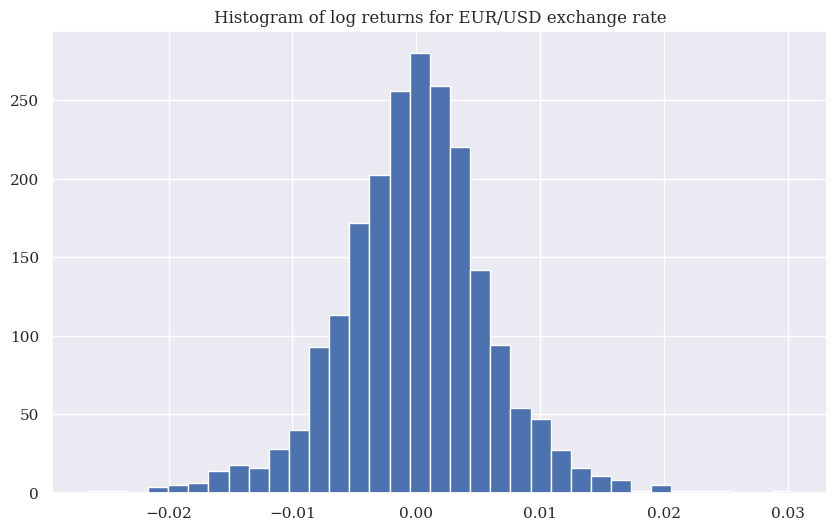

In [41]:
data['returns'].hist(bins=35, figsize=(10, 6))
plt.title('Histogram of log returns for EUR/USD exchange rate')

In [42]:
# the code that creates the feature data by lagging the log return
# visualizes it in conbinartion with returns data

lags = 2

def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)



In [43]:
create_lags(data)

In [44]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [45]:
data.dropna(inplace=True)

Text(0.5, 1.0, 'Scatter plot based on features and labels data')

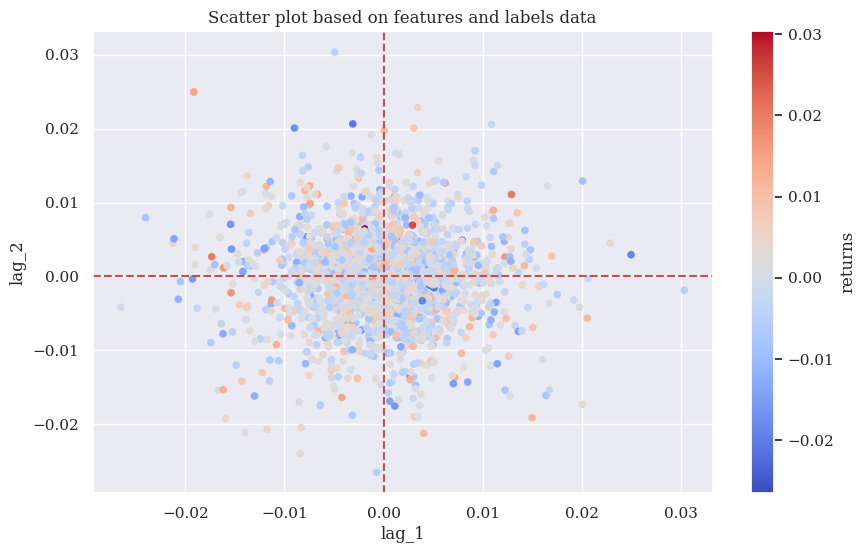

In [47]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--')
plt.title('Scatter plot based on features and labels data')

### Regression

With the data set completed, linear OLS regression can be applied to learn about any potential (linear) relationship, to predict market movement based on the features, and to backtest a trading strategy based on the predictions. Two basic approaches are available: using the log returns or only the direction data as the dependent variable during the regression.

In [48]:
# The linear OLS regression implementaation from scikit-learn is used
from sklearn.linear_model import LinearRegression   

model = LinearRegression()

In [49]:
# the regression is implemented on the log returns directly
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])

In [51]:
# and on the direction data which is of primary interest
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])

In [52]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-07,-0.000166,-0.000086
2010-01-08,0.000017,0.040404
2010-01-11,-0.000244,-0.011756
2010-01-12,-0.000139,-0.043398
2010-01-13,-0.000022,0.002237


In [53]:
# the real-valued predicitons are transformed to directional values (+1, -1)
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [54]:
# the two approach yield different directional predictions in general
data['pos_ols_1'].value_counts()

-1    1847
 1     288
Name: pos_ols_1, dtype: int64

In [55]:
data['pos_ols_2'].value_counts()

 1    1377
-1     758
Name: pos_ols_2, dtype: int64

In [58]:
# however, both lead to a relatively large number of trades over time
(data['pos_ols_1'].diff() != 0).sum()

555

In [59]:
(data['pos_ols_2'].diff() != 0).sum()

762

The analysis is based on a number of simplifying assumtions, such as "zero transaction costs" and the usage of the same data set for both training and testing. Both regression-based strategies outporform the benchmark passive investment, while only the strategy trained on the direction of the market shows a positive overall performance.

In [61]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [64]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [66]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.810644
strat_ols_1    0.942422
strat_ols_2    1.339286
dtype: float64

In [68]:
# shows the number of correct and false predictions by the strategeies
(data['direction'] == data['pos_ols_1']).value_counts()

False    1093
True     1042
dtype: int64

In [69]:
(data['direction'] == data['pos_ols_2']).value_counts()

True     1096
False    1039
dtype: int64

Text(0.5, 1.0, 'Performacne of EUR/USD and regression-based strategies over time')

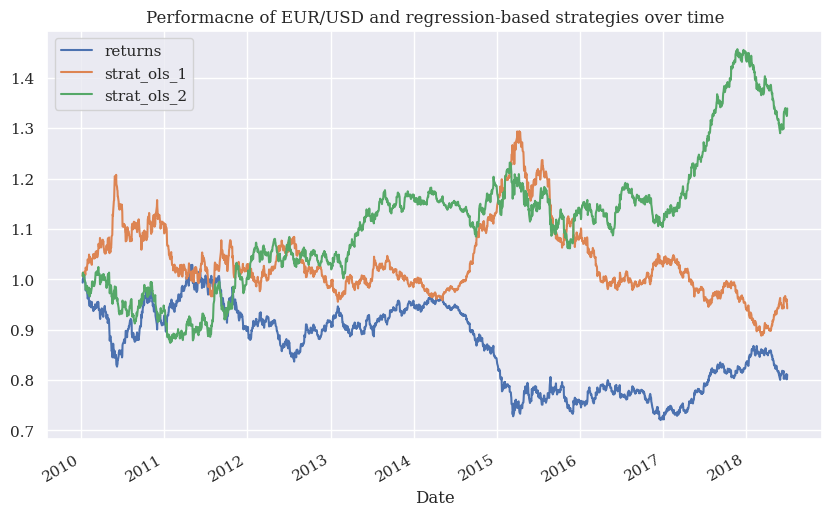

In [71]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10, 6))
plt.title('Performacne of EUR/USD and regression-based strategies over time')

## Clustering

The idea is that the K-means algorithm identifies two clusters of feature values that predict either an upward movement or a downward movement.

In [72]:
from sklearn.cluster import KMeans

# two clusters are chosen for the algorithm
model = KMeans(n_clusters=2, random_state=0)

In [73]:
model.fit(data[cols])

/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

In [74]:
data['pos_clus'] = model.predict(data[cols])

In [85]:
# given the cluster values, the position is chosen
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)

In [86]:
data['pos_clus'].values

array([-1,  1, -1, ...,  1,  1, -1])

Text(0.5, 1.0, 'Two clusters as identified by the k-means algorithm')

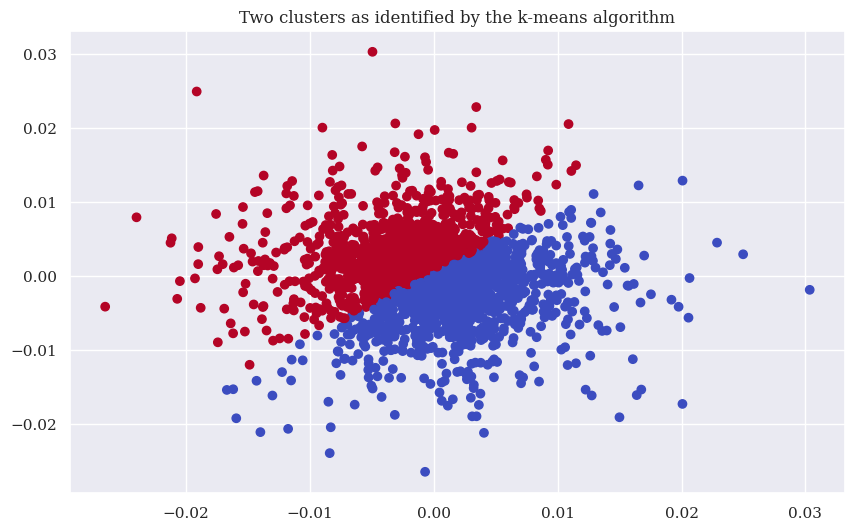

In [87]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1], c=data['pos_clus'], cmap='coolwarm')
plt.title('Two clusters as identified by the k-means algorithm')

The resulting trading strategy shows a slight outperformance at the end compared to the benchmark passive investment. It is noteworthy that no guidance (supervision) is given and that the hit ratio - i.e., the number of correct predictions in relationship to all predictions maed - is less than 50%.

In [88]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [89]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.810644
strat_clus    1.269570
dtype: float64

In [90]:
(data['direction'] == data['pos_clus']).value_counts()

True     1078
False    1057
dtype: int64

Text(0.5, 1.0, 'Performance of EUR/USD and k-means-based strategy over time')

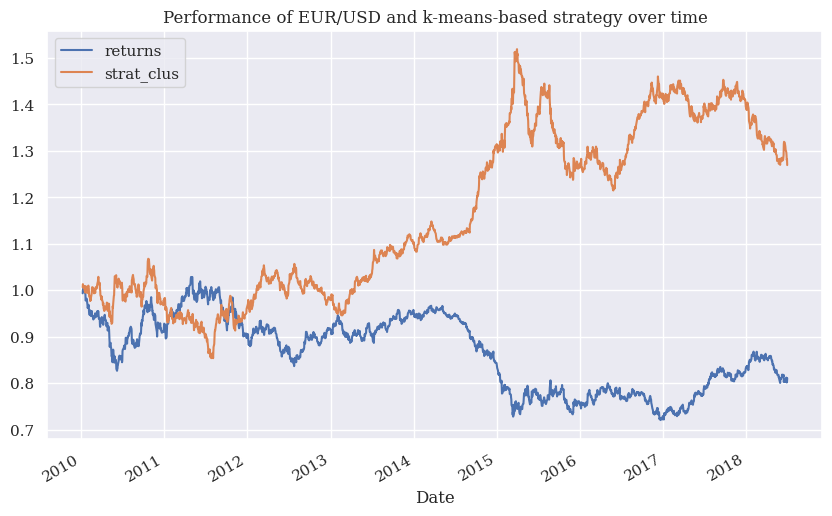

In [92]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6))
plt.title('Performance of EUR/USD and k-means-based strategy over time')

## Frequency Approach

One might come up with the idea of just implementing a frequency approach to predict directional movements in financial markets. One might transform the two real-valued features to binary ones and assess the probability of an upward and a downward movement, respectively, from the historical observations of such movements.


In [94]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        # digizies the feature values given the bins parameter
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

In [96]:
create_bins(data)

In [98]:
# shows the digitized feature values and the label values
data[cols_bin + ['direction']].head()

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1
2010-01-13,0,1,1


In [100]:
# shows the frequency of the possible movements conditiosnal on the feature value combinations
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           239
                       0             4
                       1           258
           1          -1           262
                       1           288
1          0          -1           272
                       0             1
                       1           278
           1          -1           278
                       0             4
                       1           251
dtype: int64

In [101]:
# transforms the DataFrame object to have the frequncies in columns
res = grouped['direction'].size().unstack(fill_value=0)

In [103]:
# highlights the highest-frequency value per feature value combination
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [106]:
res.style.apply(highlight_max, axis=1)  

In [107]:
# Three feature value combinations hint at a downward movement while one lets an upward movement seem more likely.FileLink

# translates the findings given the frequencies to a trading strategy
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)

In [108]:
(data['direction'] == data['pos_freq']).value_counts()

True     1102
False    1033
dtype: int64

In [109]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [110]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.810644
strat_freq    0.989513
dtype: float64

Text(0.5, 1.0, 'Performance of EUR/USD and frequency-based trading strategy over time')

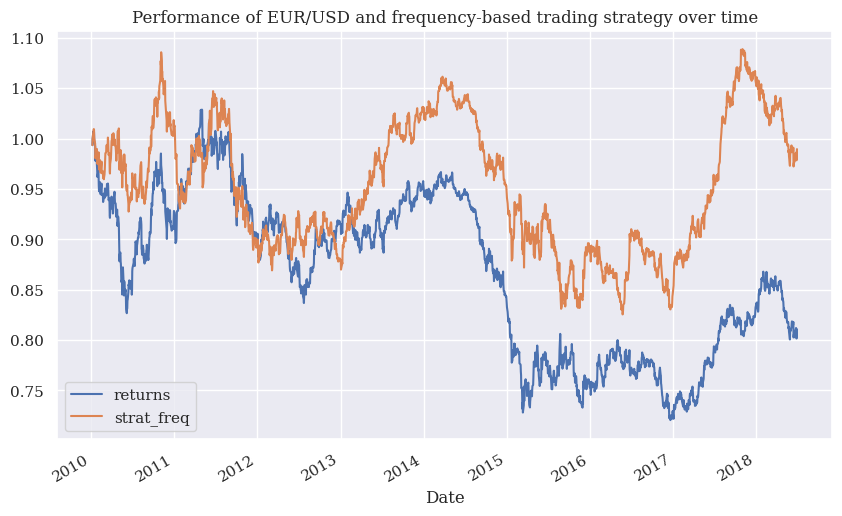

In [112]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6))
plt.title('Performance of EUR/USD and frequency-based trading strategy over time')

## Classification

### Two Binary Features

In [113]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

C = 1
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [114]:
# A function that fits all models
def fit_models(data):
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) 
            for model in models.keys()}

In [115]:
fit_models(data)

In [116]:
# a function that derives all position values form the fitted models
def derive_positions(data):
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [117]:
derive_positions(data)

In [118]:
# a function that evaluates all resulting trading strategies
def evaluate_strats(data):
    global sel 
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [120]:
evaluate_strats(data)

In [122]:
sel.insert(1, 'strat_freq')

In [123]:
# some strategies might show the exact same performance
data[sel].sum().apply(np.exp)

returns           0.810644
strat_freq        0.989513
strat_freq        0.989513
strat_log_reg     1.243322
strat_gauss_nb    1.243322
strat_svm         0.989513
dtype: float64

Text(0.5, 1.0, 'Performance of EUR/USD and classification-based trading strategies (two binary lags) over time')

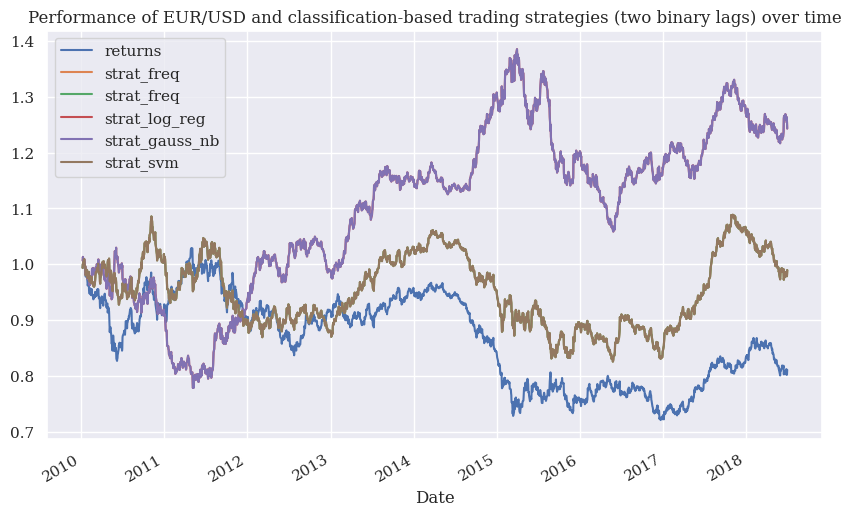

In [124]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6))
plt.title('Performance of EUR/USD and classification-based trading strategies (two binary lags) over time')

### Five Binary Features